In [58]:
%pwd

'/Users/sebbyzhao/Research/RecSys/recsys'

In [10]:
import torch
import os
import seaborn as sns
import implicit
import pandas as pd
from scipy import sparse
from numpy.linalg import svd
import numpy as np

/Users/sebbyzhao/Library/Caches/pypoetry/virtualenvs/recsys-lkkaVlXU-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
DATA_DIR = '../data/ml-100k/'

In [12]:
training_data = pd.read_csv(os.path.join(DATA_DIR, 'u1.base'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
training_data.head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [13]:
test_data = pd.read_csv(os.path.join(DATA_DIR, 'u1.test'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
test_data.head()

,user_id,item_id,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [14]:
training_data[training_data['user_id'] == 1]

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
130,1,263,1,875693007
131,1,268,5,875692927
132,1,269,5,877482427
133,1,270,5,888732827


In [15]:
rating_matrix = pd.pivot_table(training_data, values='rating', index='user_id', columns='item_id', fill_value=0)
rating_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,3,3,0,4,1,5,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
rating_proxy = rating_matrix.copy().applymap(lambda x: 1 if x > 0 else 0)
rating_proxy.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
rating_proxy_array = rating_proxy.values

In [19]:
from typing import Union

In [20]:
class ALSModel():
    def __init__(self, r, alpha=40, lmbda=50 , num_recommendations=10, num_factors=100):
        self.lmbda = lmbda
        self.users, self.items = r.shape
        # Confidence matrix
        self.c = 1 + alpha * r

        # Preference matrix
        self.p = r

        # User latent factor matrix
        self.x = np.random.rand(self.users, num_factors).astype(np.float32) * .01

        # Item latent factor matrix
        self.y = np.random.rand(self.items, num_factors).astype(np.float32) * .01

        self.num_recommendations = num_recommendations



    def least_squares_step(self, X, Y, optimize=Union['user', 'item']):
        if optimize == 'user':
            YtY = Y.T @ Y
            for i in range(X.shape[0]):
                Cu = np.diag(self.c[i])
                A = YtY + Y.T @ (Cu - np.identity(Y.shape[0])) @ Y + self.lmbda * np.identity(Y.shape[1])
                b = Y.T @ Cu @ self.p[i]
                X[i] = np.linalg.solve(A, b)
        elif optimize == 'item':
            XtX = X.T @ X
            for j in range(Y.shape[0]):
                Ci = np.diag(self.c[:, j])
                A = XtX + X.T @ (Ci - np.identity(X.shape[0])) @ X + self.lmbda * np.identity(X.shape[1])
                b = X.T @ Ci @ self.p[:, j]
                Y[j] = np.linalg.solve(A, b)
        
    def loss(self):
        # Calculate loss to make sure it's decreasing.
        total = 0
        for i in range(self.x.shape[0]):
            for j in range(self.y.shape[0]):
                confidence = self.c[i][j]
                total += confidence * (self.p[i][j] - self.x[i] @ self.y[j]) ** 2 

        total += self.lmbda * (np.sum(self.x ** 2) + np.sum(self.y ** 2))
        return total


    def backward(self):
        # Update user latent factor matrix
            
        self.least_squares_step(self.x, self.y, optimize='user')
        self.least_squares_step(self.x, self.y, optimize='item')

    def forward(self, X):
        return X @ self.y.T


In [61]:
previous_score = None
user_score = None
true_pref = None
top_index = None

def apk(recommendations, true_prefs):
    """
    recommendations: List[Int] = list of recommendations of items by index suggested
    true_prefs: List[Int] = list of ground truth items user likes
    """
    count = 0
    total = 0

    for i in range(len(recommendations)):
        seen = i + 1
        recommendation = recommendations[i]
        if recommendation in true_prefs:
            count += 1
            total += count / seen
    
    return 1 / min(len(recommendations), len(true_prefs)) * total

def validation(training_data, test_data, model, k=10):
    # Get top completions
    item_scores = model.x @ model.y.T

    apks = []
    for i in range(len(item_scores)):
        user_id = i + 1
        user_scores = item_scores[i]
        previously_scored = training_data[training_data['user_id'] == user_id]['item_id'].values - 1

        all_items = np.arange(0, len(user_scores))
        user_scores[np.isin(all_items, previously_scored)] = -np.inf

        # True prefs
        true_prefs = test_data[test_data['user_id'] == user_id]['item_id'].values - 1

        # Sort and calculate metric
        if len(true_prefs) > 0:
            top_indexes = np.argsort(user_scores)[::-1]
            apks.append(apk(top_indexes[:10], true_prefs))

    return np.mean(apks)
    

def train(model,num_epochs=10):
    proxy_losses = []
    true_losses = []
    for i in range(num_epochs):
        print("===\nEpoch: ", i)
        model.backward()
        loss = model.loss()
        print("Validation Loss: ", loss)
        proxy_losses.append(model.loss())
        true_loss = validation(training_data, test_data, model)
        print("Proxy Loss: ", true_loss)
        true_losses.append(true_loss)

    return model, proxy_losses, true_losses


In [62]:
model = ALSModel(rating_proxy_array)

In [65]:
model, proxy_losses, true_losses = train(model, 10)

===
Epoch:  0


<Axes: >

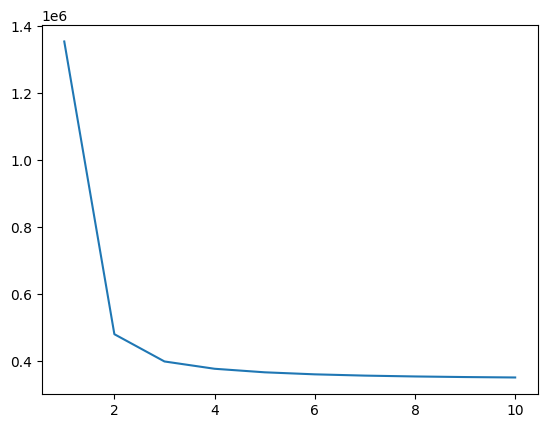

In [132]:
sns.lineplot(x=range(1, len(losses)+1), y=losses)

In [136]:
a = pd.read_csv(os.path.join(DATA_DIR, 'ua.base'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp']).head()

In [137]:
b = pd.read_csv(os.path.join(DATA_DIR, 'ua.test'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp']).head()

In [ ]:
# In order to determine a validation set, 

In [146]:
# Calculate mapK by making predictions on everything excluding training dataset?